In [16]:
!kaggle datasets download -d splcher/animefacedataset
!unzip -q /content/animefacedataset.zip

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
animefacedataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace images/0_2000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace images/10000_2004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Define paths
anime_faces_folder = '/content/images'

# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load half of anime faces
anime_files = os.listdir(anime_faces_folder)
random.shuffle(anime_files)
anime_files = anime_files[:len(anime_files)//2]
anime_images = [os.path.join(anime_faces_folder, f) for f in anime_files]
anime_labels = [0] * len(anime_images)

# Create dataset and dataloader
dataset = ImageDataset(image_paths=anime_images, labels=anime_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)


In [ ]:
len(anime_images)

In [ ]:
# ResNet Block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.block1 = ResNetBlock(3, 32, stride=2)
        self.block2 = ResNetBlock(32, 64, stride=2)
        self.fc = nn.Linear(64 * 16 * 16, latent_dim)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        z = self.fc(x)
        return z

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 16 * 16)
        self.block1 = ResNetBlock(64, 32, stride=1)
        self.block2 = ResNetBlock(32, 3, stride=1)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 64, 16, 16)
        x = self.up1(x)
        x = self.block1(x)
        x = self.up2(x)
        x = self.block2(x)
        x_reconstructed = torch.sigmoid(x)
        x_reconstructed = x_reconstructed.view(-1, 3, 64, 64)
        return x_reconstructed

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # Calculate distances
        distances = (torch.sum(inputs**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(inputs, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)

        return loss, quantized

In [ ]:
class VQVAE(nn.Module):
    def __init__(self, latent_dim):
        super(VQVAE, self).__init__()

        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)

        self.vq = VectorQuantizer(512, latent_dim, 0.25)

        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        loss, quantized = self.vq(z)
        recon_x = self.decoder(quantized)

        return loss, recon_x

In [ ]:
latent_dim = 128  # Adjust as per your choice

In [ ]:
import numpy as np

def generate_image(model):
    model.eval()
    with torch.no_grad():
        # Sample from the latent space (assuming standard normal distribution for simplicity)
        z = torch.randn(8, latent_dim).to(device)

        _, quantized_z = model.vq(z)
        generated_image = model.decoder(quantized_z)
        generated_image = generated_image.squeeze(0).cpu().detach().numpy()  # Convert tensor to numpy array

    # Rescale pixel values to range [0, 1]
    generated_image = np.clip(generated_image, 0, 1)

    # Plot the generated image
    plt.figure(figsize=(6*8, 6))
    for i in range(8):
        plt.subplot(1, 8, i + 1)
        plt.imshow(np.transpose(generated_image[i], (1,2,0)))
        plt.axis("off")
    plt.show()


4375395
Epoch [1/6], Batch [1/497], Loss: 1.1227
Epoch [1/6], Batch [101/497], Loss: 1.1984
Epoch [1/6], Batch [201/497], Loss: 0.7828
Epoch [1/6], Batch [301/497], Loss: 0.6796
Epoch [1/6], Batch [401/497], Loss: 0.6519


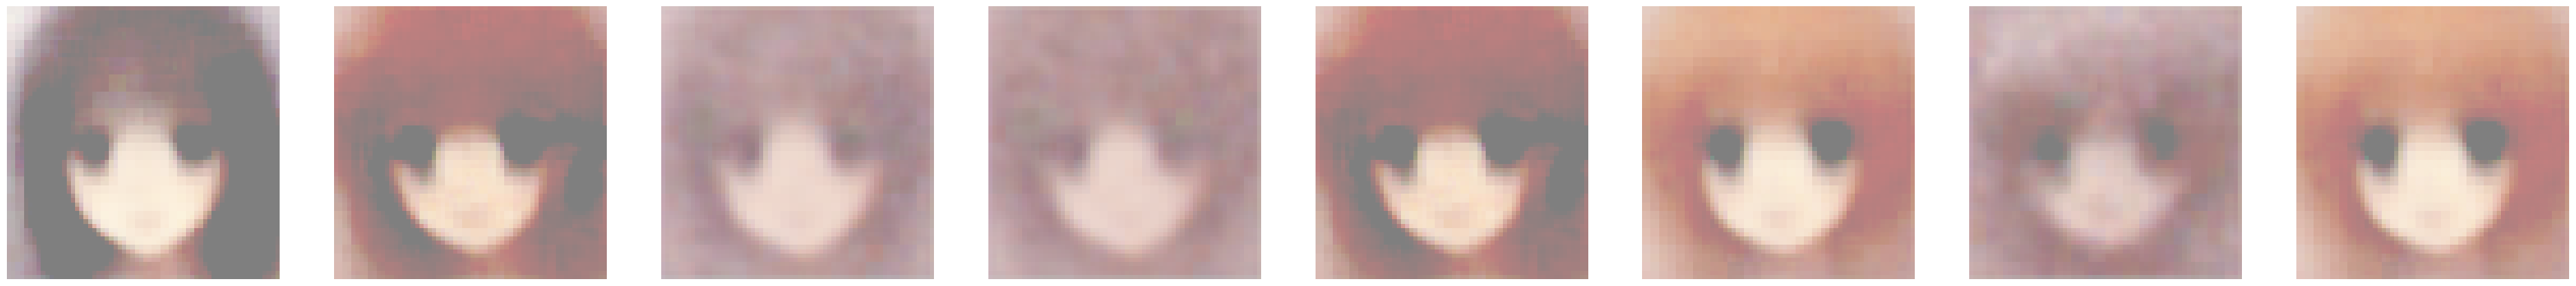

Epoch [1/6], Total Loss: 1.4281
Epoch [1/6], Total Recon Loss: 1.2109
Epoch [2/6], Batch [1/497], Loss: 0.6445
Epoch [2/6], Batch [101/497], Loss: 0.6558
Epoch [2/6], Batch [201/497], Loss: 0.6535
Epoch [2/6], Batch [301/497], Loss: 0.6567
Epoch [2/6], Batch [401/497], Loss: 0.6533


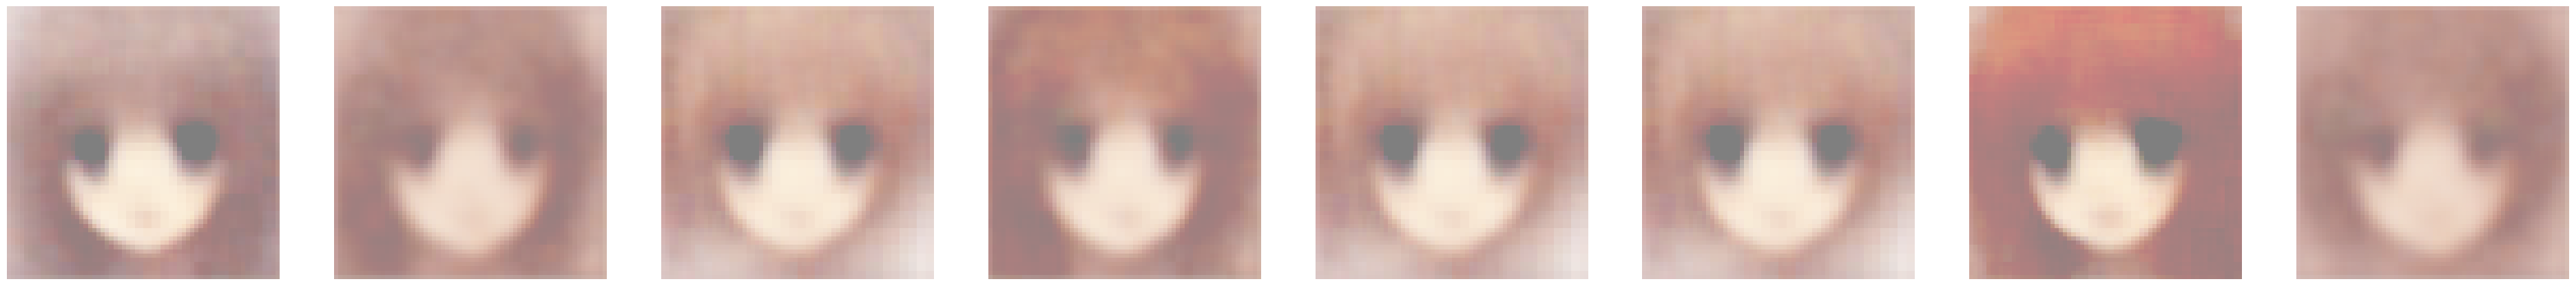

Epoch [2/6], Total Loss: 0.6452
Epoch [2/6], Total Recon Loss: 1.1897
Epoch [3/6], Batch [1/497], Loss: 0.6282
Epoch [3/6], Batch [101/497], Loss: 0.6386
Epoch [3/6], Batch [201/497], Loss: 0.6455
Epoch [3/6], Batch [301/497], Loss: 0.6226
Epoch [3/6], Batch [401/497], Loss: 0.6299


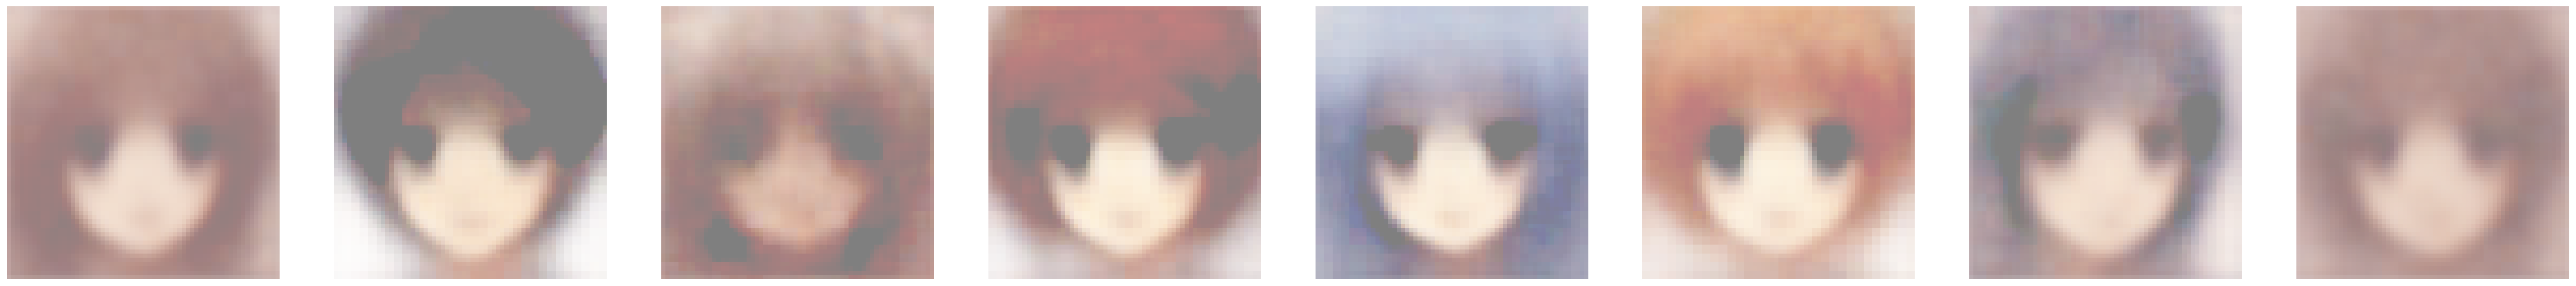

Epoch [3/6], Total Loss: 0.6357
Epoch [3/6], Total Recon Loss: 1.1840
Epoch [4/6], Batch [1/497], Loss: 0.6389
Epoch [4/6], Batch [101/497], Loss: 0.6258
Epoch [4/6], Batch [201/497], Loss: 0.6250
Epoch [4/6], Batch [301/497], Loss: 0.6321
Epoch [4/6], Batch [401/497], Loss: 0.6269


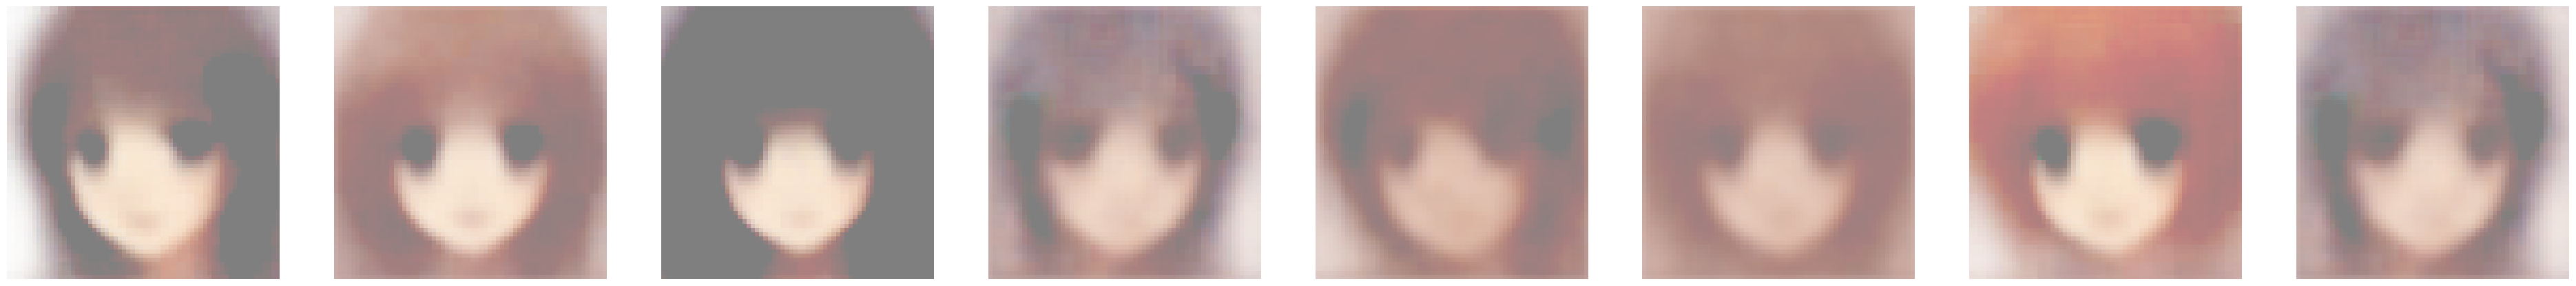

Epoch [4/6], Total Loss: 0.6325
Epoch [4/6], Total Recon Loss: 1.1813
Epoch [5/6], Batch [1/497], Loss: 0.6378
Epoch [5/6], Batch [101/497], Loss: 0.6313
Epoch [5/6], Batch [201/497], Loss: 0.6293
Epoch [5/6], Batch [301/497], Loss: 0.6369
Epoch [5/6], Batch [401/497], Loss: 0.6250


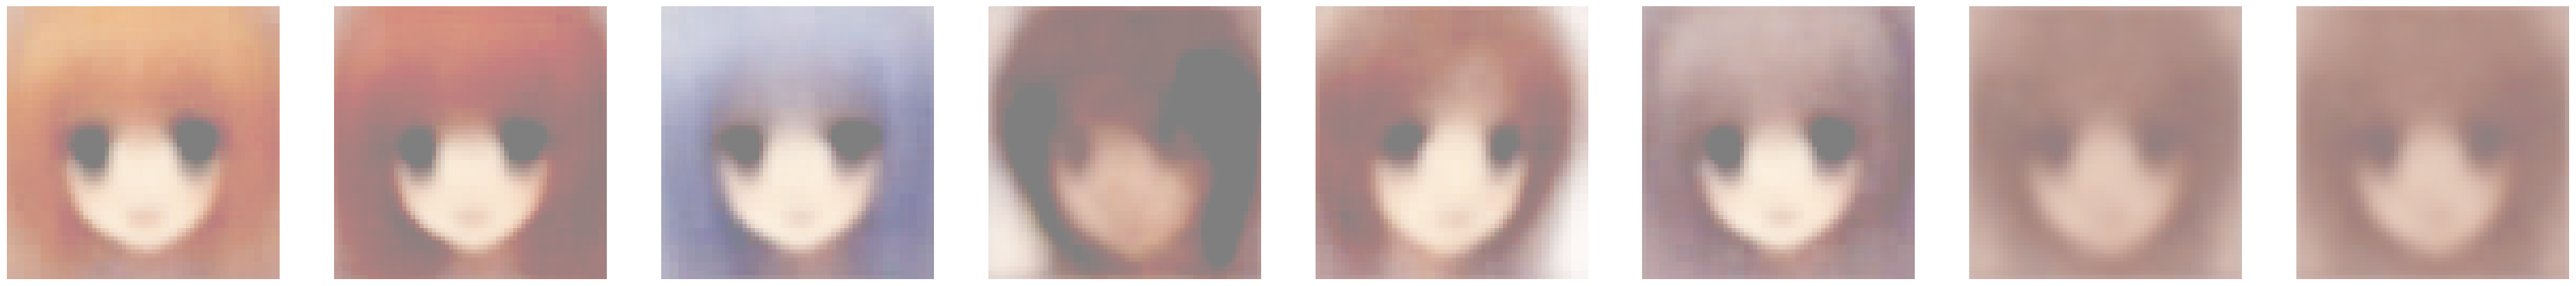

Epoch [5/6], Total Loss: 0.6289
Epoch [5/6], Total Recon Loss: 1.1797
Epoch [6/6], Batch [1/497], Loss: 0.6222
Epoch [6/6], Batch [101/497], Loss: 0.6305
Epoch [6/6], Batch [201/497], Loss: 0.6267
Epoch [6/6], Batch [301/497], Loss: 0.6286
Epoch [6/6], Batch [401/497], Loss: 0.6307


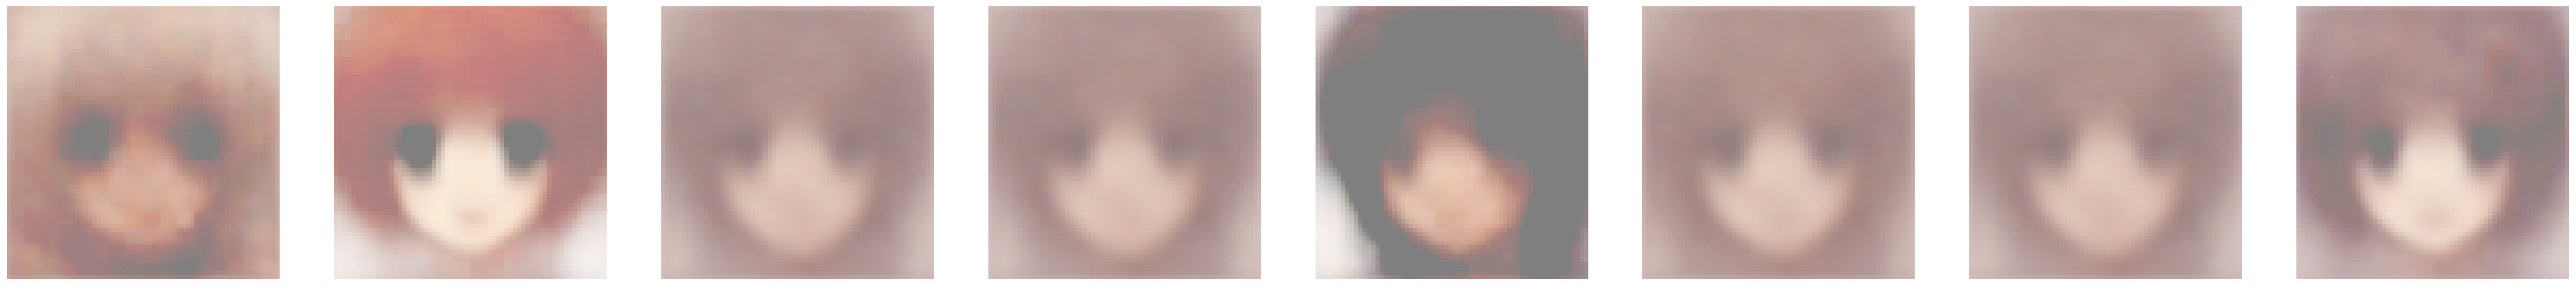

Epoch [6/6], Total Loss: 0.6261
Epoch [6/6], Total Recon Loss: 1.1782


In [29]:
# Initialize VQVAE model
loss_ = []
r_l = []
vq_l = []
model = VQVAE(latent_dim).to(device)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 6
for epoch in range(num_epochs):
    model.train()
    total_recon_loss = 0
    total_loss=0
    total_vq_ll = 0
    for batch_idx, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        vq_loss, recon_x = model(x)
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')
        loss = recon_loss + vq_loss

        loss.backward()
        optimizer.step()

        total_recon_loss += recon_loss.item()
        total_loss += loss.item()
        total_vq_ll += vq_loss.item()

        total_recon_loss += recon_loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    generate_image(model)
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss / len(dataloader):.4f}")
    loss_.append(total_loss / len(dataloader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Recon Loss: {total_recon_loss / len(dataloader):.4f}")
    r_l.append(total_recon_loss / len(dataloader))

# Save trained model
torch.save(model.state_dict(), 'vqvae_model.pth')


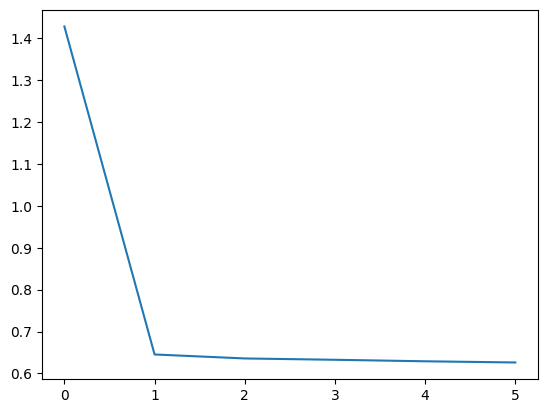

In [30]:
plt.plot([np.mean(l) for l in loss_])

---------------------------------------------------------------------------------------------------------------------------

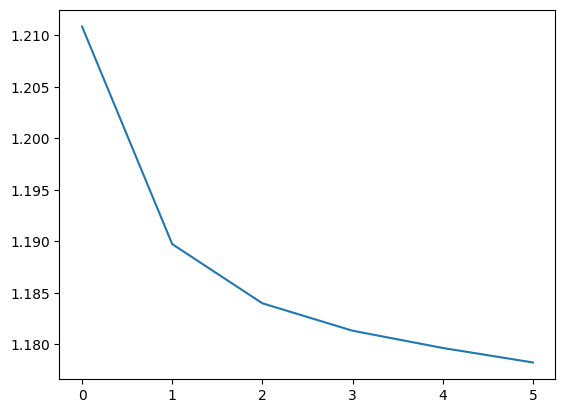

In [31]:
plt.plot([np.mean(l) for l in r_l])

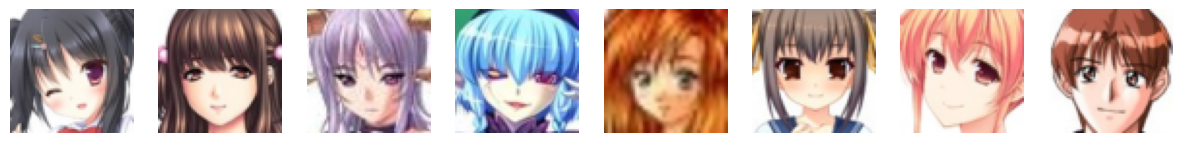

In [32]:
# Randomly sample 5 images
random_images = random.sample(range(len(dataset)), 8)

# Display the images
plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_images):
    ax = plt.subplot(1, 8, i + 1)
    plt.imshow(np.transpose(dataset[idx][0].numpy(), (1,2,0)))
    plt.axis("off")
plt.show()

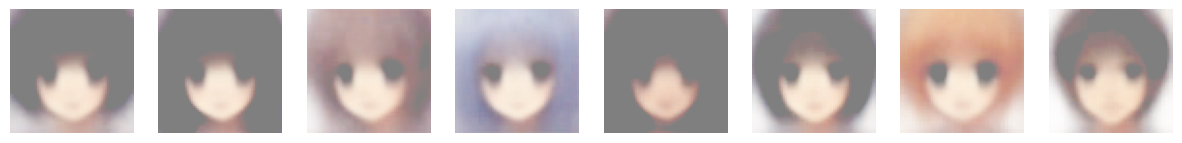

In [33]:
# Randomly sample 5 images
# random_images = random.sample(range(len(dataset)), 5)

# Display the images
plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_images):
    recon_img = model(dataset[idx][0].to(device).view(1, 3, 64, 64))[1]
    print()
    ax = plt.subplot(1, 8, i + 1)
    plt.imshow(np.transpose(recon_img.cpu().detach().numpy().reshape(3, 64, 64), (1,2,0)))
    plt.axis("off")
plt.show()

In [37]:
!unzip 'generated_images.zip'

Archive:  generated_images.zip
   creating: generated_images/
 extracting: generated_images/generated_image_1.png  
 extracting: generated_images/generated_image_2.png  
 extracting: generated_images/generated_image_3.png  
 extracting: generated_images/generated_image_4.png  
 extracting: generated_images/generated_image_5.png  
 extracting: generated_images/generated_image_6.png  
 extracting: generated_images/generated_image_7.png  
 extracting: generated_images/generated_image_8.png  


In [38]:
folder_path = "/content/generated_images"
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
images = []

for file in image_files:
    image = Image.open(os.path.join(folder_path, file)).convert('RGB')
    image = image.resize((64, 64))  # Resize if necessary
    images.append(image)


In [39]:
def preprocess_image(image):
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    image = np.transpose(image, (2, 0, 1))  # Change from HWC to CHW
    image = torch.tensor(image, dtype=torch.float32)  # Convert to tensor
    return image

preprocessed_images = [preprocess_image(img) for img in images]


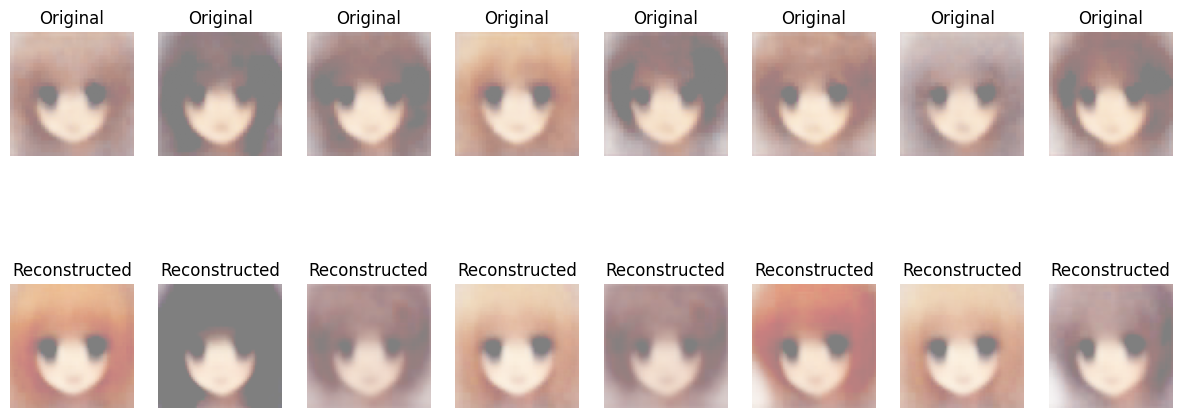

In [41]:
# Assuming 'model' is your trained model and 'device' is your target device (e.g., 'cpu')
model.to(device)

plt.figure(figsize=(15, 6))
num_images_to_display = min(len(preprocessed_images), 8)  # Display up to 5 images or as many as available

for i in range(num_images_to_display):
    img_tensor = preprocessed_images[i].to(device).unsqueeze(0)  # Add batch dimension
    recon_img = model(img_tensor)[1]  # Replace with your model's output
    recon_img = recon_img.cpu().detach().numpy().reshape(3, 64, 64)

    # Display original image
    ax = plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(np.transpose(preprocessed_images[i].cpu().numpy(), (1, 2, 0)))  # Convert back to HWC
    plt.title("Original")
    plt.axis("off")

    # Display reconstructed image
    ax = plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(np.transpose(recon_img, (1, 2, 0)))  # Convert back to HWC
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()
